In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint


# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import TwoModels
from sklift.models import ClassTransformation

# sklift поддерживает любые модели, которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [4]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}, inplace=True)

In [7]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [8]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((48000, 8), (48000,), (16000, 8), (16000,))

In [10]:
# One-Hot Encoding:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [11]:
# Заведем переменные

treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

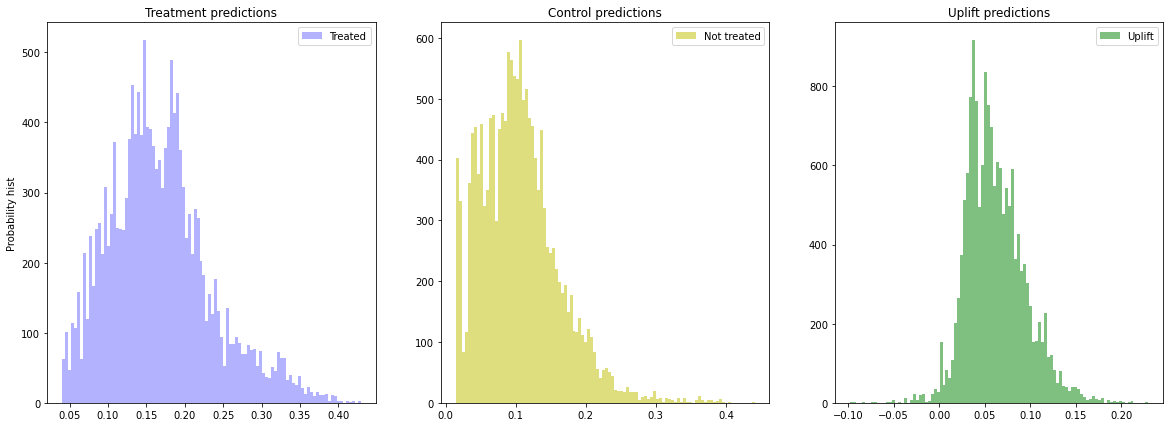

In [12]:
# - одна модель с признаком коммуникации (S learner),¶
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [13]:
# Посмотрим на топ-признаки
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,18.155308
1,treatment,17.942577
2,used_bogo,12.768646
3,recency,12.061491
4,history,11.675302
5,used_discount,9.292318
6,zip_code_Rural,6.891349
7,channel_Phone,4.794693
8,channel_Web,3.307677
9,zip_code_Surburban,1.397088


In [14]:
# - модель с трансформацией таргета (трансформация классов п. 2. 1)
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-14-f37bc1f50bc3>:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


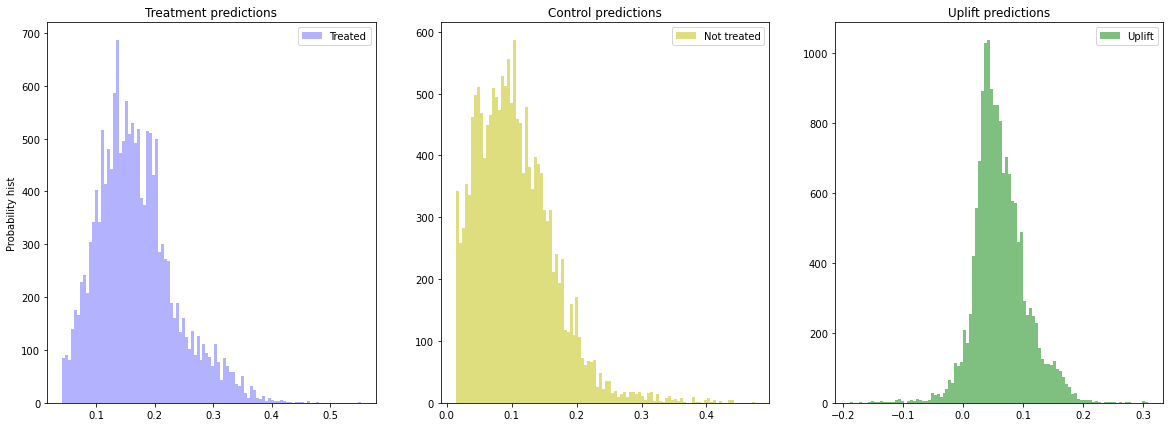

In [15]:
# - вариант с двумя независимыми моделями
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [16]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False).set_index('approach')

,uplift@10%,uplift@20%
approach,,
ClassTransformation,0.237697,0.171296
SoloModel,0.067078,0.062906
TwoModels,0.049152,0.060307
